In [36]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


## 1. Load the Datasets

In [37]:
# Load energy data
energy_df = pd.read_csv('../data/energy_import_export.csv')

# Load solar self-consumption data
solar_df = pd.read_csv('../data/solar_self_consumption_main_building.csv')

# Load meteorological data
met_df = pd.read_csv('../data/met_data.csv')


In [38]:
solar_df.head()
# drop columns "Unnamed: 0"
solar_df = solar_df.drop(columns=['Unnamed: 0'])

## 2. Preprocess the Data

### 2.1 Convert Timestamps to Datetime Objects

In [39]:
# Convert timestamp columns to datetime
energy_df['Tidspunkt'] = pd.to_datetime(energy_df['Tidspunkt'], format="mixed")
solar_df['starting_at'] = pd.to_datetime(solar_df['starting_at'], format='mixed')

# remove utc from the time string
met_df['starting_at'] = met_df['starting_at'].str.split('+').str[0]
met_df['starting_at'] = pd.to_datetime(met_df['starting_at'], format='mixed')




### 2.2 Rename Columns for Consistency

In [40]:
energy_df.rename(columns={
    'Energikilde': 'energy_source',
    'Retning': 'direction',
    'Målernavn': 'meter_name',
    'Måler-Id': 'meter_id',
    'Verdi': 'value',
    'Tidspunkt': 'timestamp'
}, inplace=True)


solar_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)
met_df.rename(columns={
    'starting_at': 'timestamp'
}, inplace=True)


### 2.3 Map Property IDs to Meter IDs

In [41]:
meter_property_mapping = {
    '707057500042745649': 10724, #main building
    '707057500038344962': 10703, # building A
    '707057500085390523': 4462, # building B
    '707057500042201572': 4746 # building C
}
id_to_name_property_mapping= {
    10724: 'main building',
    10703: 'building A',
    4462: 'building B',
    4746: 'building C'
}
def get_name(id):
    return id_to_name_property_mapping[id]

energy_df['meter_id'] = energy_df['meter_id'].astype(str)
energy_df['meter_id'] = energy_df['meter_id'].str.strip()

energy_df['property_id'] = energy_df['meter_id'].map(meter_property_mapping)
energy_df['building'] = energy_df['property_id'].map(id_to_name_property_mapping)

energy_df.tail()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building
54471,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,27.40,2024-09-04 23:00:00,10703,building A
54472,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,31.50,2024-09-04 23:00:00,4746,building C
54473,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2024-09-04 23:00:00,10724,main building
54474,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.76,2024-09-04 23:00:00,4462,building B
54475,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,38.60,2024-09-04 23:00:00,10724,main building


### 2.4 Merge Datasets

In [42]:
# Resample met_df to daily (mean aggregation)
# met_df_daily = met_df.set_index('timestamp').resample('D').mean().reset_index()
# met_df_daily["timestamp"] = pd.to_datetime(met_df_daily["timestamp"].dt.date)

merged_df = pd.merge(energy_df, met_df, on=['property_id', 'timestamp'], how='left')


In [43]:
merged_df.tail()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
54471,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,27.40,2024-09-04 23:00:00,10703,building A,16.2,1.4,281.6,0.4,0.0
54472,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,31.50,2024-09-04 23:00:00,4746,building C,18.2,4.8,14.4,0.0,0.0
54473,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.00,2024-09-04 23:00:00,10724,main building,17.4,1.8,356.1,0.9,0.0
54474,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,27.76,2024-09-04 23:00:00,4462,building B,15.6,0.9,243.3,0.9,0.0
54475,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,38.60,2024-09-04 23:00:00,10724,main building,17.4,1.8,356.1,0.9,0.0


In [44]:
met_df.tail()

,property_id,timestamp,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
41179,10724,2023-07-01 01:00:00,13.2,2.0,246.5,0.4,0.0
41180,4462,2023-07-01 00:00:00,12.0,0.7,220.3,0.5,0.0
41181,4746,2023-07-01 00:00:00,15.2,3.9,247.0,0.2,0.0
41182,10703,2023-07-01 00:00:00,12.9,1.0,275.7,0.7,0.0
41183,10724,2023-07-01 00:00:00,13.6,1.6,251.5,0.5,0.0


In [45]:
# Check for missing values
print("total number of rows", merged_df.shape[0])
print("rows missing weather data \n",merged_df.isnull().sum())

# Fill or drop missing values as appropriate
# merged_df.dropna(inplace=True)
rows_with_missing_values = merged_df[merged_df.isnull().any(axis=1)]
rows_with_missing_values.head()


total number of rows 54476
rows missing weather data 
 energy_source       0
direction           0
meter_name          0
meter_id            0
value               0
timestamp           0
property_id         0
building            0
temperature       385
wind_speed        385
wind_direction    385
cloud_fraction    385
precipitation     385
dtype: int64


,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation
29071,Elektrisitet,EXPORT,Hovedmåler,707057500042745649,0.0,2024-02-06 06:00:00,10724,main building,NaN,NaN,NaN,NaN,NaN
29072,Elektrisitet,IMPORT,Hovedmåler,707057500038344962,37.4,2024-02-06 06:00:00,10703,building A,NaN,NaN,NaN,NaN,NaN
29073,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,37.8,2024-02-06 06:00:00,10724,main building,NaN,NaN,NaN,NaN,NaN
29074,Elektrisitet,IMPORT,Hovedmåler,707057500042201572,46.4,2024-02-06 06:00:00,4746,building C,NaN,NaN,NaN,NaN,NaN
29075,Elektrisitet,IMPORT,Hovedmåler,707057500085390523,34.4,2024-02-06 06:00:00,4462,building B,NaN,NaN,NaN,NaN,NaN


In [46]:
# Separate import (consumption) and export (production)
import_df = merged_df[merged_df['direction'] == 'IMPORT']
export_df = merged_df[merged_df['direction'] == 'EXPORT']


In [47]:
# For property_id 10724 (main building)
main_building_import = import_df[import_df['property_id'] == 10724]

main_building_export = export_df[export_df['property_id'] == 10724]

# Merge with solar self-consumption data
main_building_df = pd.merge(main_building_import, solar_df, left_on='timestamp', right_on='timestamp', how='left')

# Replace NaN in solar_consumption with 0
main_building_df['solar_consumption'].fillna(0, inplace=True)

# Calculate total consumption including self-consumed solar energy
main_building_df['total_consumption'] = main_building_df['value'] + main_building_df['solar_consumption']


/var/folders/b0/slnc__2x31jczblnsfgfmjw00000gn/T/ipykernel_94228/1695209657.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  main_building_df['solar_consumption'].fillna(0, inplace=True)


In [48]:
main_building_df.head(1)

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01,10724,main building,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687


In [49]:
# Get import data for reference buildings
ref_buildings = [10703, 4462, 4746]
ref_buildings_df = import_df[import_df['property_id'].isin(ref_buildings)]

# Aggregate data to daily or monthly consumption if needed
main_daily_consumption = main_building_df.groupby(main_building_df['timestamp'].dt.date)['value'].sum()#.reset_index()

ref_daily_consumption = ref_buildings_df.groupby(['property_id', ref_buildings_df['timestamp'].dt.date])['value'].sum().reset_index()



In [50]:
# Identify hourly peaks
main_building_peaks = main_building_df.groupby(main_building_df['timestamp'].dt.month)['total_consumption'].max()#.reset_index()
ref_buildings_peaks = ref_buildings_df.groupby(['property_id', ref_buildings_df['timestamp'].dt.month])['value'].max().reset_index()


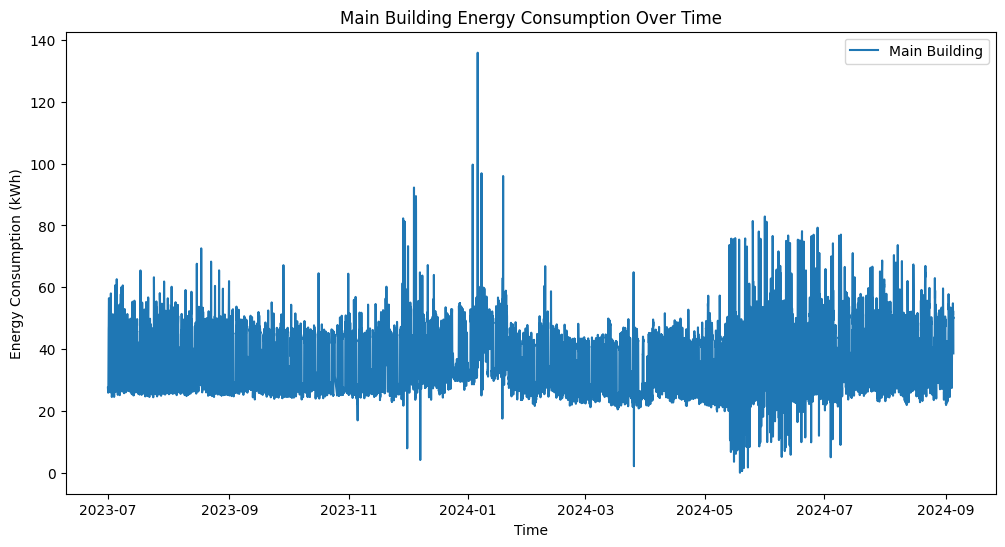

In [51]:
# Plot total consumption over time for the main building
plt.figure(figsize=(12,6))
plt.plot(main_building_df['timestamp'], main_building_df['total_consumption'], label='Main Building')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Main Building Energy Consumption Over Time')
plt.legend()
plt.show()


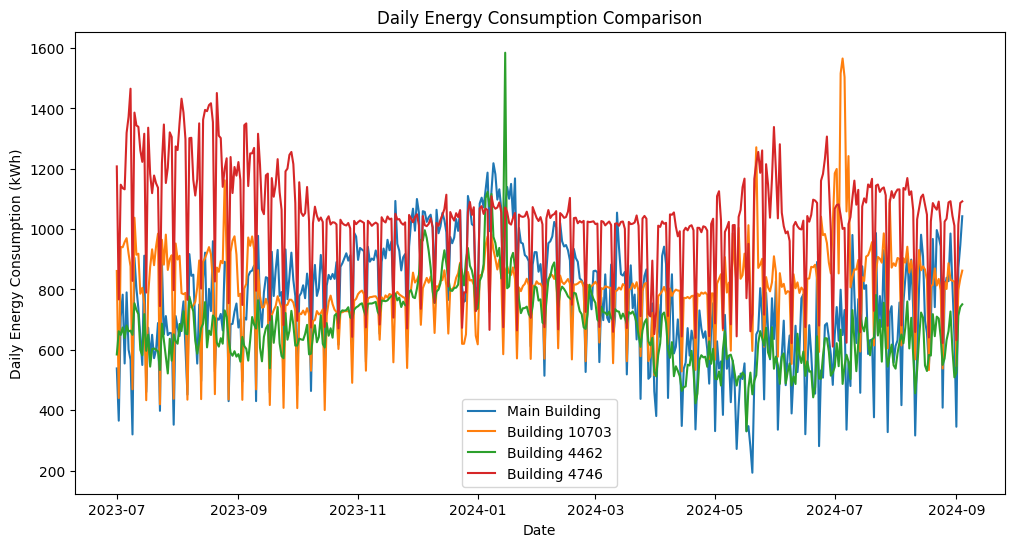

In [52]:
# Plot average daily consumption
plt.figure(figsize=(12,6))
sns.lineplot(data=main_daily_consumption, label='Main Building')
for pid in ref_buildings:
    data = ref_daily_consumption[ref_daily_consumption['property_id'] == pid]
    sns.lineplot(x='timestamp', y='value', data=data, label=f'Building {pid}')
plt.xlabel('Date')
plt.ylabel('Daily Energy Consumption (kWh)')
plt.title('Daily Energy Consumption Comparison')
plt.legend()
plt.show()


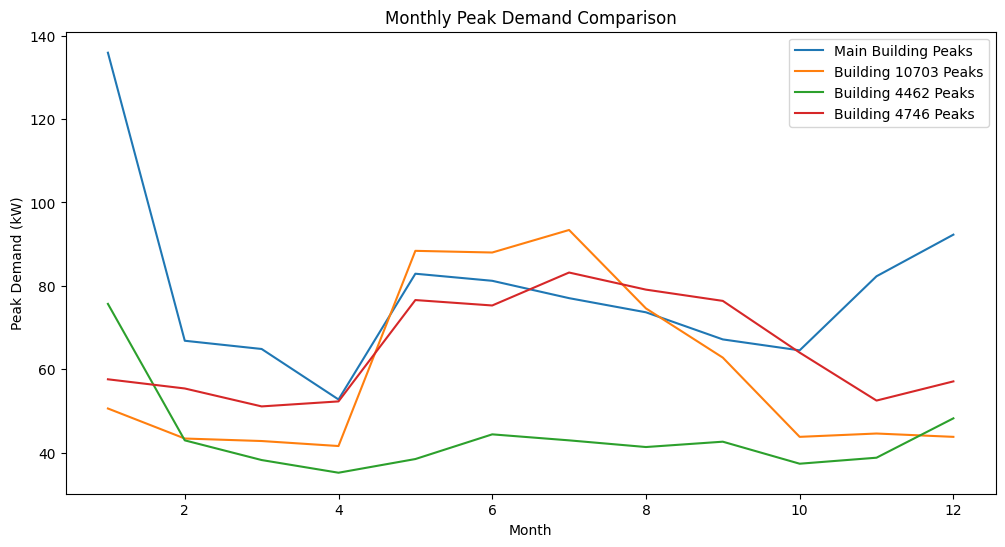

In [53]:
# Plot monthly peak demand
plt.figure(figsize=(12,6))
plt.plot(main_building_peaks.index, main_building_peaks.values, label='Main Building Peaks')
for pid in ref_buildings:
    data = ref_buildings_peaks[ref_buildings_peaks['property_id'] == pid]
    plt.plot(data['timestamp'], data['value'], label=f'Building {pid} Peaks')
plt.xlabel('Month')
plt.ylabel('Peak Demand (kW)')
plt.title('Monthly Peak Demand Comparison')
plt.legend()
plt.show()


In [54]:
main_building_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01 00:00:00,10724,main building,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687
1,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,2023-07-01 01:00:00,10724,main building,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750
2,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,2023-07-01 02:00:00,10724,main building,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937
3,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,2023-07-01 03:00:00,10724,main building,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,2023-07-01 04:00:00,10724,main building,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035


In [55]:
# Merge main building data with meteorological data
main_met_df = main_building_df
main_met_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01 00:00:00,10724,main building,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687
1,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,2023-07-01 01:00:00,10724,main building,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750
2,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,2023-07-01 02:00:00,10724,main building,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937
3,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,2023-07-01 03:00:00,10724,main building,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,2023-07-01 04:00:00,10724,main building,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035


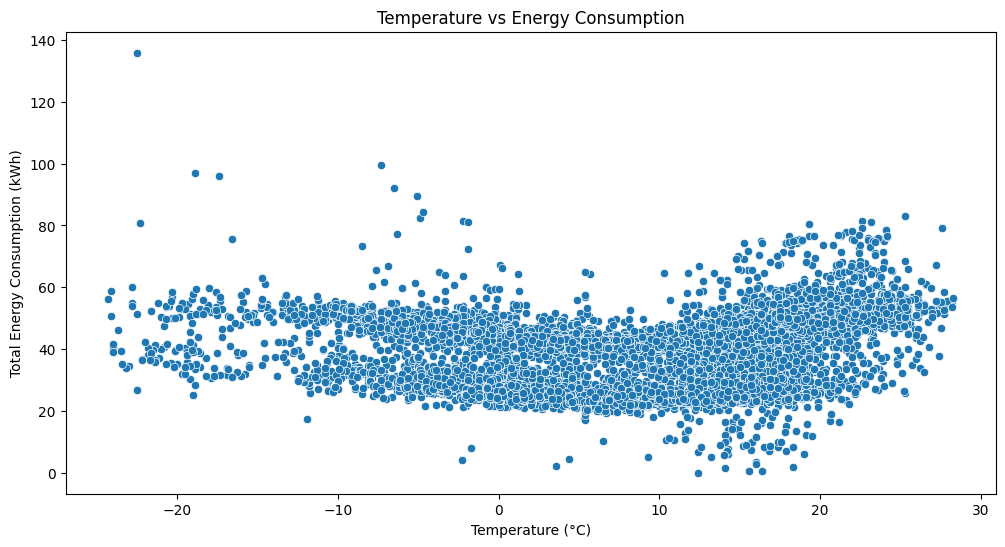

In [56]:
# Analyze correlation between temperature and energy consumption
plt.figure(figsize=(12,6))
sns.scatterplot(x='temperature', y='total_consumption', data=main_met_df)
plt.xlabel('Temperature (°C)')
plt.ylabel('Total Energy Consumption (kWh)')
plt.title('Temperature vs Energy Consumption')
plt.show()


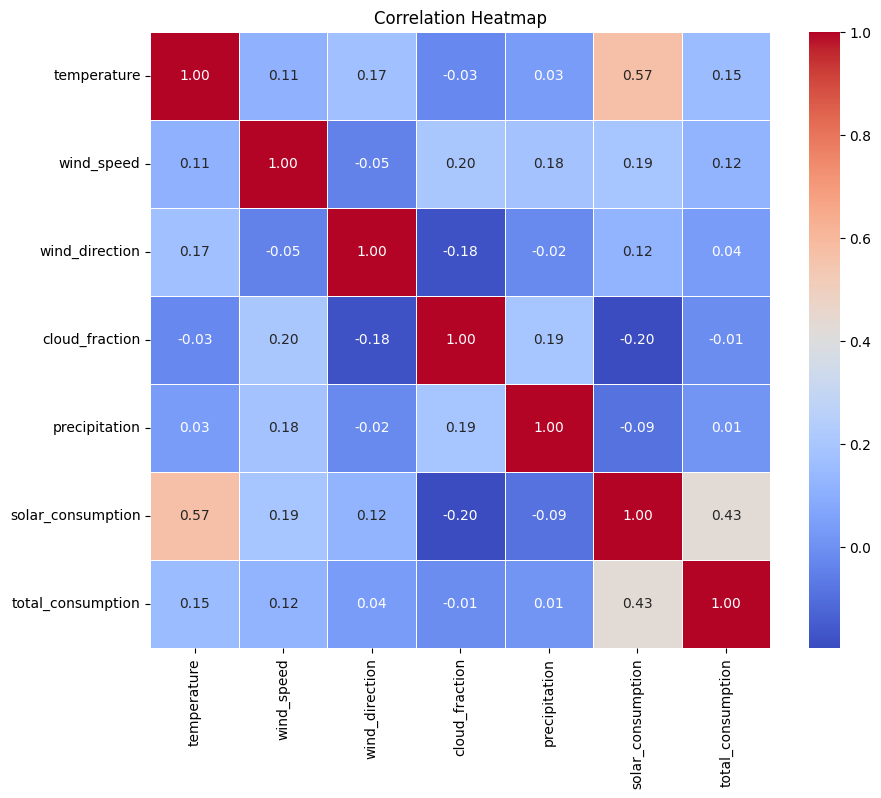

In [57]:
# det hadde kanskje gitt mer mening å se på korrelasjonen været og solforbruk / export.
correlation_columns = ['temperature', 'wind_speed', 'wind_direction', 'cloud_fraction', 
                       'precipitation', 'solar_consumption', 'total_consumption']

correlation_matrix = main_met_df[correlation_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f')

plt.title('Correlation Heatmap')
plt.show()


# TODO list
- se på hvor mye som eksporteres.
- Sammenligne import og eksport for byggingene
    - se på peeks for import. Det er det som gir høyre kostnader.
- Sol produksjon = solforbuk + eksport 

## 3. Task 1: Analyze the Amount of Energy Exported

Total Exported Energy for Main Building (kWh): 4945.83


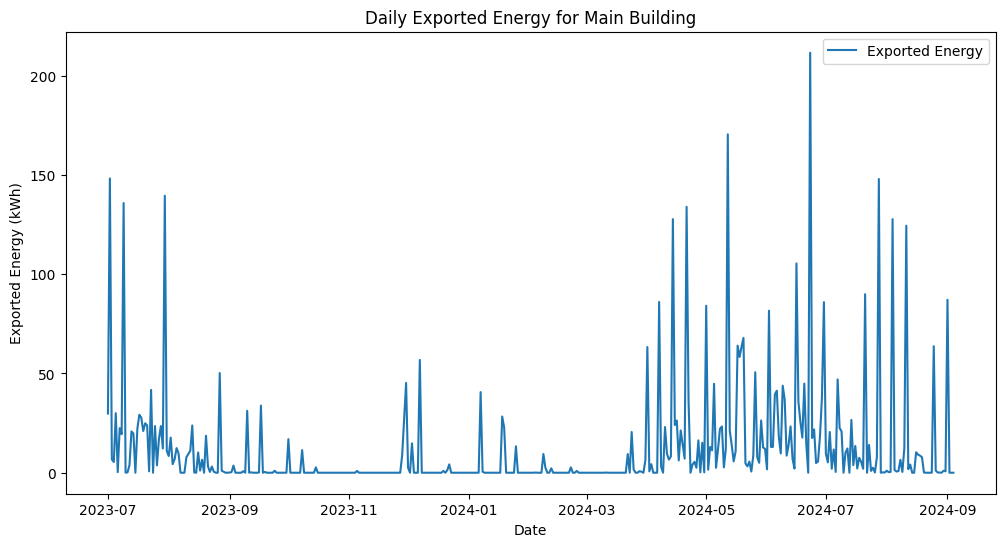

In [58]:
# Sum of exported energy for the main building
total_export_main = main_building_export['value'].sum()
print(f"Total Exported Energy for Main Building (kWh): {total_export_main:.2f}")

# Exported energy over time
main_export_daily = main_building_export.groupby(main_building_export['timestamp'].dt.date)['value'].sum()

plt.figure(figsize=(12,6))
plt.plot(main_export_daily.index, main_export_daily.values, label='Exported Energy')
plt.xlabel('Date')
plt.ylabel('Exported Energy (kWh)')
plt.title('Daily Exported Energy for Main Building')
plt.legend()
plt.show()



## 4. Task 2: Compare Import and Export for the Buildings


### 4.1 Visualize Import vs. Export

   property_id  total_import  total_export
0         4462     292527.46          7.68
1         4746     446010.64          0.00
2        10703     345302.86          0.00
3        10724     325692.39       4945.83


/var/folders/b0/slnc__2x31jczblnsfgfmjw00000gn/T/ipykernel_94228/2747916354.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  import_export_total['total_export'].fillna(0, inplace=True)


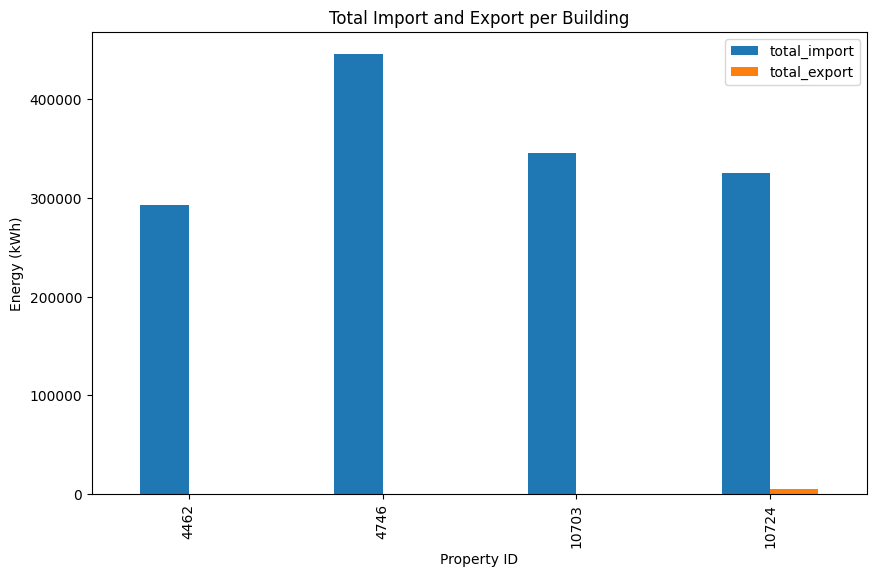

In [59]:
# Filter import and export data for all buildings
import_df = energy_df[energy_df['direction'] == 'IMPORT']
export_df = energy_df[energy_df['direction'] == 'EXPORT']

# List of all property IDs including main and reference buildings
all_buildings = [10724, 10703, 4462, 4746]

# Total import and export per building
import_total = import_df.groupby('property_id')['value'].sum().reset_index(name='total_import')
export_total = export_df.groupby('property_id')['value'].sum().reset_index(name='total_export')

# Merge import and export totals
import_export_total = pd.merge(import_total, export_total, on='property_id', how='left')
import_export_total['total_export'].fillna(0, inplace=True)

# Display the totals
print(import_export_total)
# Plot import and export comparison
import_export_total.set_index('property_id', inplace=True)
import_export_total[['total_import', 'total_export']].plot(kind='bar', figsize=(10,6))
plt.xlabel('Property ID')
plt.ylabel('Energy (kWh)')
plt.title('Total Import and Export per Building')
plt.legend()
plt.show()



### 4.2 Analyze Import Peaks (Which Lead to Higher Costs)

#### 4.2.1 Identify Peak Import Hours for Each Building

In [60]:
def find_peak_import(import_df: pd.DataFrame) -> pd.DataFrame:
    # Note that it is not only about having a low energy consumption but also important to reduce the monthly max kW peak as a high peak will give high tariffs.
    # TODO: skal vi finne peak per time eller forbrukt for en dag eller en uke eller en måned?
    import_df['month'] = import_df['timestamp'].dt.to_period('M')
    peak_import = import_df.groupby(['property_id', 'month'])['value'].max().reset_index()
    return peak_import

peak_import_df = find_peak_import(import_df)


/var/folders/b0/slnc__2x31jczblnsfgfmjw00000gn/T/ipykernel_94228/3067908121.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_df['month'] = import_df['timestamp'].dt.to_period('M')


#### 4.2.2 Visualize Peak Import

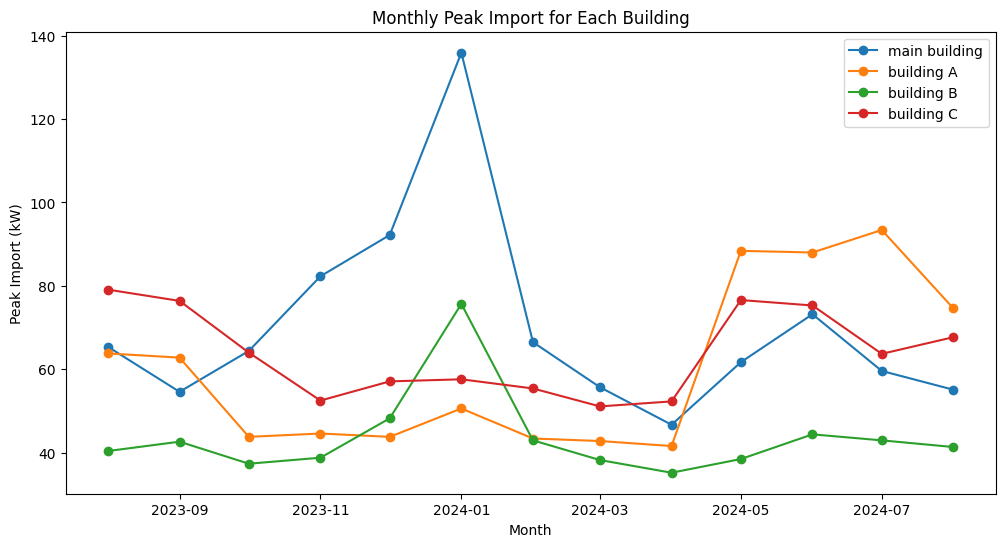

In [61]:
# Plot peak import for each building
plt.figure(figsize=(12,6))
for pid in all_buildings:
    data = peak_import_df[peak_import_df['property_id'] == pid]
    data = data[1:-1]# skip the first and last value to avoid half weeks.
    plt.plot(data['month'].dt.to_timestamp(), data['value'], marker='o', label=f'{get_name(pid)}')
plt.xlabel('Month')
plt.ylabel('Peak Import (kW)')
plt.title('Monthly Peak Import for Each Building')
plt.legend()
plt.show()


In [62]:
# Compare average peak imports
average_peaks = peak_import_df.groupby('property_id')['value'].mean().reset_index(name='average_peak')
average_peaks["building"] = average_peaks["property_id"].apply(get_name)
print(average_peaks)


   property_id  average_peak       building
0         4462     43.109333     building B
1         4746     64.713333     building C
2        10703     59.213333     building A
3        10724     68.213333  main building


### 5. Task 3: Calculate Solar Production as Solar Consumption Plus Export
#### 5.1 Calculate Solar Production for the Main Building

In [63]:
main_building_df.head()

,energy_source,direction,meter_name,meter_id,value,timestamp,property_id,building,temperature,wind_speed,wind_direction,cloud_fraction,precipitation,solar_consumption,total_consumption
0,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.5,2023-07-01 00:00:00,10724,main building,13.6,1.6,251.5,0.5,0.0,0.002687,27.502687
1,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,27.1,2023-07-01 01:00:00,10724,main building,13.2,2.0,246.5,0.4,0.0,0.002750,27.102750
2,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.8,2023-07-01 02:00:00,10724,main building,12.3,1.6,260.4,0.3,0.0,0.002937,26.802937
3,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,25.9,2023-07-01 03:00:00,10724,main building,11.9,0.6,285.0,0.9,0.0,0.003062,25.903062
4,Elektrisitet,IMPORT,Hovedmåler,707057500042745649,26.4,2023-07-01 04:00:00,10724,main building,11.9,0.2,295.8,0.8,0.0,0.000035,26.400035


In [64]:
# Solar production = solar consumption + export
# Sum solar consumption
total_solar_consumption = main_building_df['solar_consumption'].sum()

# Sum exported energy
total_solar_export = main_building_export['value'].sum()

# Total solar production
total_solar_production = total_solar_consumption + total_solar_export
print(f"Total Solar Production for Main Building (kWh): {total_solar_production:.2f}")


Total Solar Production for Main Building (kWh): 82518.47


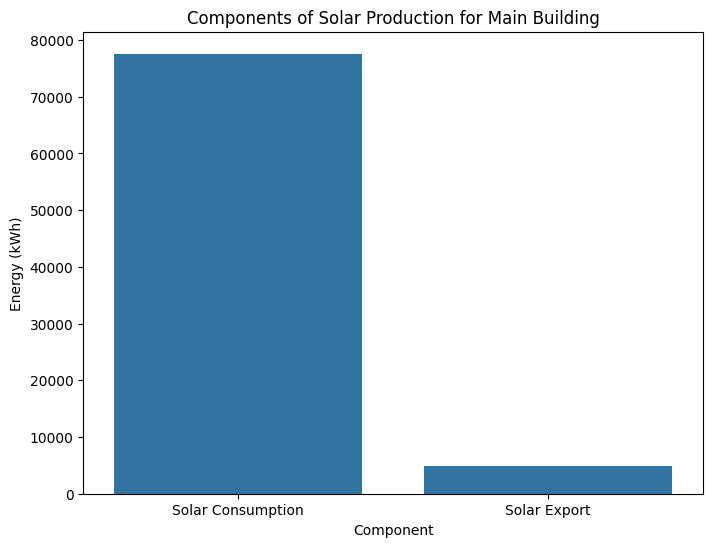

In [65]:
# Create a DataFrame for visualization
solar_components = pd.DataFrame({
    'Component': ['Solar Consumption', 'Solar Export'],
    'Energy (kWh)': [total_solar_consumption, total_solar_export]
})

# Plotting the components
plt.figure(figsize=(8,6))
sns.barplot(x='Component', y='Energy (kWh)', data=solar_components)
plt.title('Components of Solar Production for Main Building')
plt.ylabel('Energy (kWh)')
plt.show()


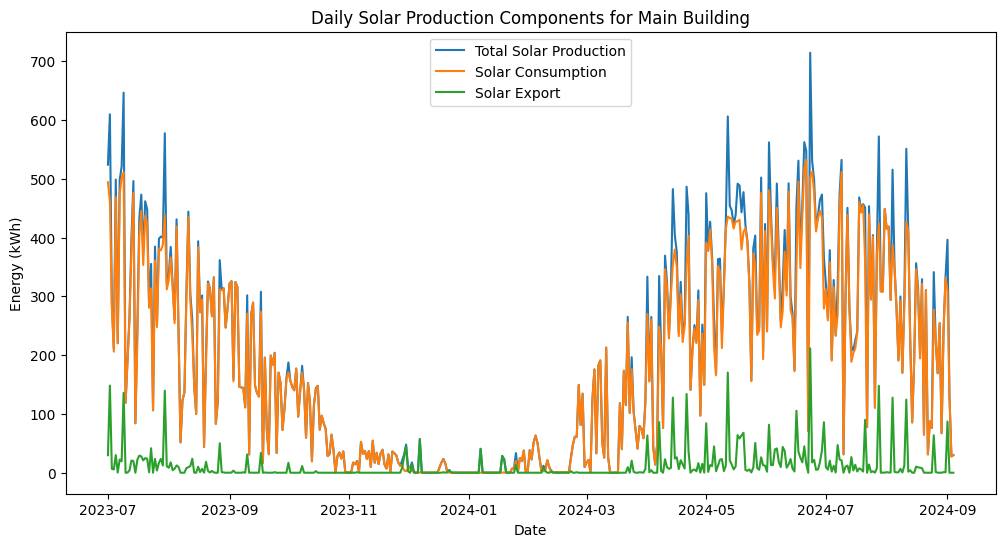

In [66]:
# Merge solar consumption and export data
solar_export = main_building_export[['timestamp', 'value']].rename(columns={'value': 'solar_export'})
solar_production = pd.merge(main_building_df[['timestamp', 'solar_consumption']], solar_export, on='timestamp', how='outer')
solar_production.fillna(0, inplace=True)
solar_production['total_solar_production'] = solar_production['solar_consumption'] + solar_production['solar_export']

# Set timestamp as index
solar_production.set_index('timestamp', inplace=True)

# Resample to daily totals
solar_daily_production = solar_production.resample('D').sum()

# Plot daily solar production
plt.figure(figsize=(12,6))
plt.plot(solar_daily_production.index, solar_daily_production['total_solar_production'], label='Total Solar Production')
plt.plot(solar_daily_production.index, solar_daily_production['solar_consumption'], label='Solar Consumption')
plt.plot(solar_daily_production.index, solar_daily_production['solar_export'], label='Solar Export')
plt.xlabel('Date')
plt.ylabel('Energy (kWh)')
plt.title('Daily Solar Production Components for Main Building')
plt.legend()
plt.show()


### 6. energy import per square meter
#### 6.1 Normalize Energy Consumption by Building Area

In [67]:
# Building areas (in m²)
building_areas = {
    10724: 1199,  # Main building
    10703: 1167,
    4462: 1095,
    4746: 1384
}

# Add building areas to import_export_total DataFrame
import_export_total['area_m2'] = import_export_total.index.map(building_areas)

# Calculate energy consumption per m²
import_export_total['import_per_m2'] = import_export_total['total_import'] / import_export_total['area_m2']
import_export_total['export_per_m2'] = import_export_total['total_export'] / import_export_total['area_m2']

# Display normalized values
import_export_total[['total_import', 'import_per_m2', 'total_export', 'export_per_m2']]


,total_import,import_per_m2,total_export,export_per_m2
property_id,,,,
4462,292527.46,267.148365,7.68,0.007014
4746,446010.64,322.262023,0.00,0.000000
10703,345302.86,295.889340,0.00,0.000000
10724,325692.39,271.636689,4945.83,4.124962


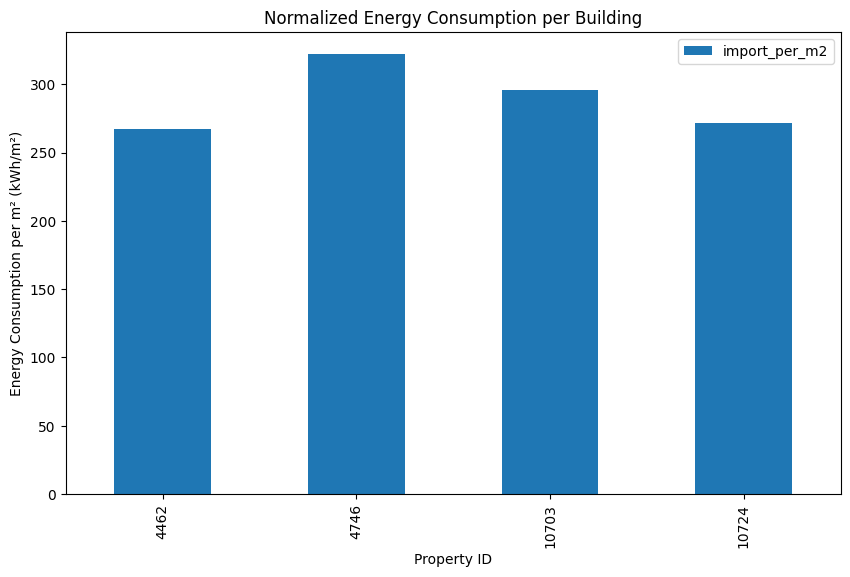

In [68]:
import_export_total[['import_per_m2']].plot(kind='bar', figsize=(10,6))
plt.xlabel('Property ID')
plt.ylabel('Energy Consumption per m² (kWh/m²)')
plt.title('Normalized Energy Consumption per Building')
plt.legend()
plt.show()


### 7. Correlate Import Peaks with Meteorological Data
#### 7.1 Merge Import Data with Meteorological Data

In [69]:
# Merge import data with meteorological data
import_met_df = pd.merge(import_df, met_df, left_on=['property_id', 'timestamp'], right_on=['property_id', 'timestamp'], how='left')

# For main building only
main_import_met = import_met_df[import_met_df['property_id'] == 10724]

# Merge import data with meteorological data
import_met_df = pd.merge(import_df, met_df, left_on=['property_id', 'timestamp'], right_on=['property_id', 'timestamp'], how='left')

# For main building only
main_import_met = import_met_df[import_met_df['property_id'] == 10724]



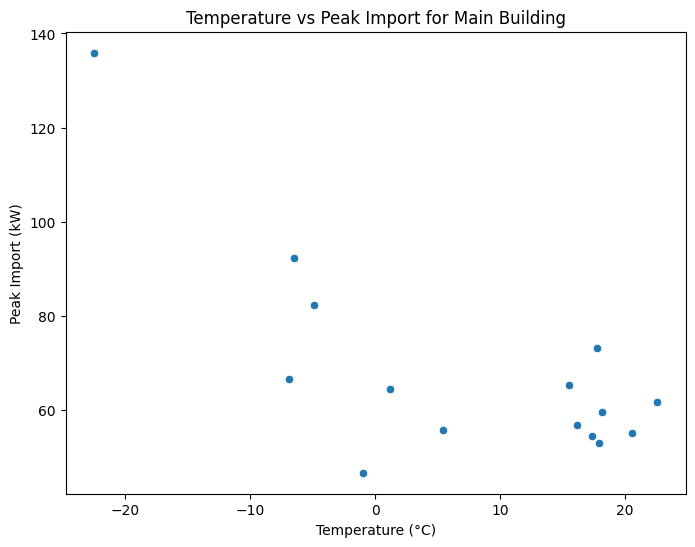

In [70]:
# Extract peak import times for main building
main_peaks = main_import_met.groupby(main_import_met['timestamp'].dt.to_period('M')).apply(lambda x: x.loc[x['value'].idxmax()])

# Plot temperature vs peak import
plt.figure(figsize=(8,6))
sns.scatterplot(x='temperature', y='value', data=main_peaks)
plt.xlabel('Temperature (°C)')
plt.ylabel('Peak Import (kW)')
plt.title('Temperature vs Peak Import for Main Building')
plt.show()
